# Build a brain model for decilitated cell

In [1]:
from brian2 import *
from brian2tools import *


WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
import numpy as np
import pandas as pd

In [3]:
dt = 5e-05 * second
dt

50. * usecond

## Load the data

In [4]:
df_v = pd.read_csv('decilliated_v_pos.csv')
df_ic = pd.read_csv('decilliated_ic_pos.csv')
df_v_neg = pd.read_csv('decilliated_v_neg.csv')
df_ic_neg = pd.read_csv('decilliated_ic_neg.csv')
df_inoise = pd.read_csv('decilliated_i_noise.csv')
df_wn_v = pd.read_csv('decilliated_v_noise.csv')

#### Get V positive

In [5]:
Vout = df_v.to_numpy()
Vout = Vout[:, 2:]

In [6]:
Vout_neg = df_v_neg.to_numpy()
Vout_neg = Vout_neg[:, 2:]

In [7]:
np.shape(Vout)

(20, 22399)

In [8]:
Vout

array([[-0.02855869, -0.02865738, -0.02878897, ..., -0.02867383,
        -0.02862449, -0.02865738],
       [-0.02873963, -0.02862449, -0.02873963, ..., -0.02609142,
        -0.0263217 , -0.02602562],
       [-0.02829552, -0.02832841, -0.02803234, ..., -0.02829552,
        -0.02827907, -0.02844355],
       ...,
       [-0.02564731, -0.02572955, -0.0257131 , ..., -0.02423274,
        -0.02424918, -0.02433143],
       [-0.02439722, -0.02418339, -0.02428208, ..., -0.02276882,
        -0.02257144, -0.02270302],
       [-0.02135425, -0.02138714, -0.02122266, ..., -0.02329517,
        -0.02314713, -0.02311424]])

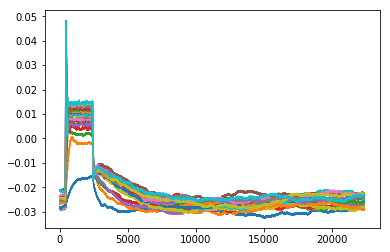

In [9]:
plot(Vout.transpose());

#### Get positive injection current

In [10]:
Ic = df_ic.to_numpy()
Ic = Ic[:, 1:]

In [11]:
Ic_neg = df_ic_neg.to_numpy()
Ic_neg = Ic_neg[:, 1:]

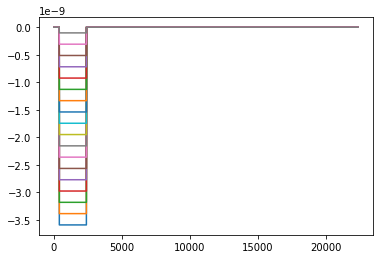

In [12]:
plot(Ic_neg.transpose());

#### Get white noise injection

In [13]:
Inoise = df_inoise.to_numpy()
Inoise = Inoise[:, 1:].transpose()[0]

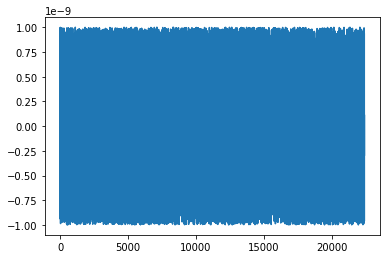

In [14]:
plot(Inoise);

#### Get V from white noise

In [15]:
Vnoise = df_wn_v.to_numpy()
Vnoise

array([[ 0.00000000e+00, -2.14199251e-02],
       [ 1.00000000e+00, -2.11783904e-02],
       [ 2.00000000e+00, -1.81857748e-02],
       ...,
       [ 2.23970000e+04, -1.97739284e-02],
       [ 2.23980000e+04, -2.02280022e-02],
       [ 2.23990000e+04, -2.24099003e-02]])

In [16]:
Vnoise = Vnoise[1:, 1:].transpose()[0]
Vnoise

array([-0.02117839, -0.01818577, -0.01544201, ..., -0.01977393,
       -0.020228  , -0.0224099 ])

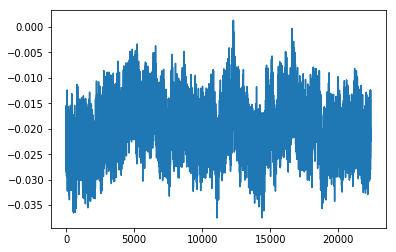

In [17]:
plot(Vnoise);

### Concatinate the data

In [18]:
np.shape(Vnoise[:10000])

(10000,)

In [19]:
np.shape(Vout[:, :10000])

(20, 10000)

In [20]:
output = np.concatenate((Vout[:, :10000], Vout_neg[:, :10000], [Vnoise[:10000]]))
np.shape(output)

(39, 10000)

In [21]:
input_cur = np.concatenate((Ic[:,:10000], Ic_neg[:, :10000], [Inoise[:10000]]))
np.shape(input_cur)

(39, 10000)

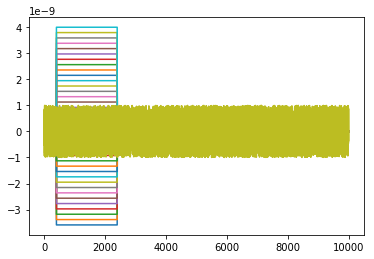

In [22]:
plot(input_cur.transpose());

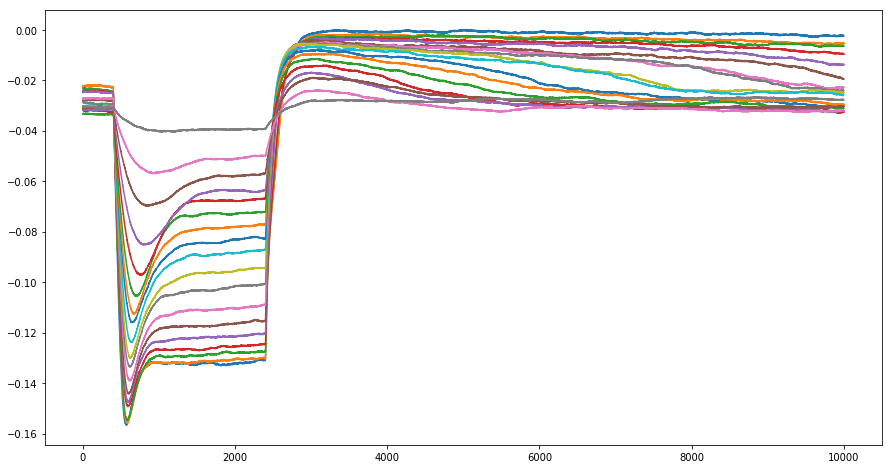

In [23]:
plt.figure(figsize=(15,8))
plot(output[20:-1].transpose());

## Build a model

#### Test if Model Works

In [24]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*n*(Ek - v) + I(t))/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
''',
# C = 130*pF,
C = 300*pF,
EL = -30*mV,
gL = 1/50*1/Mohm)
# gL = 1/142*1/Mohm)

In [25]:
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA
I = TimedArray(input_current0, dt=dt)

In [26]:
G = NeuronGroup(1, model, method='exponential_euler')
G.set_states({'g_k': 1, 'kn': 1, 'taun': 1, 'Vn': 1, 'Ek': 1}, units=False)
run(10*ms)

## Run Model Fitting

In [27]:
model = Equations('''
dv/dt = (gL * (EL - v) + g_k*(n**4)*(Ek - v) + I)/C : volt
dn/dt = (1-n)*alpha - beta*n : 1

alpha = (1/(2 * kn * taun)) * ((v-Vn) / (1-exp((Vn-v)/kn))): Hz
beta = (-1/(2 * kn * taun)) * ((v-Vn) / (1-exp((v-Vn)/kn))): Hz
g_k : siemens (constant)
kn : volt (constant)
taun : second (constant)
Vn: volt (constant)
Ek: volt (constant)
C: farad (constant)
EL: volt (constant)
gL: siemens (constant)
''',
)

In [28]:
start_scope()
n_opt = NevergradOptimizer(method='DE')
metric = MSEMetric()


In [29]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [30]:
# set_device('cpp_standalone', directory='parallel', clean=False)

In [31]:
res, error = fit_traces(model=model, input_var='I', output_var='v',
                        input=input_cur[20:] * amp, output=output[20:] * volt, dt=dt,
                        method='exponential_euler',
                        callback=callback,
                        EL=[-50*mV, -10*mV],
                        C=[100*pF, 400*pF],
                        gL=[7*nS, 20*nS],                        
                        kn=[5*mV, 20*mV],
                        Vn=[-20*mV, 20*mV],
                        Ek=[-100*mV, 0*mV],
                        g_k=[1e-2*uS, 1e2*uS],
                        taun=[0.1*ms, 40*ms],
                        param_init={'v': -30 * mV},
                        n_rounds=40, n_samples=30, optimizer=n_opt, metric=None)

index 0 errors minimum: 0.0009531950800436375
index 1 errors minimum: 0.0004830509752221438
index 2 errors minimum: 0.00040399697735818673
index 3 errors minimum: 0.00031283330139489455
index 4 errors minimum: 0.00027995352796620444
index 5 errors minimum: 0.00026273488266328267
index 6 errors minimum: 0.00026181596789579215
index 7 errors minimum: 0.00024748288921838186
index 8 errors minimum: 0.00025197033616966493
index 9 errors minimum: 0.00024124504267101593
index 10 errors minimum: 0.00024471759377982954
index 11 errors minimum: 0.00023535102832277852
index 12 errors minimum: 0.0002375770457117131
index 13 errors minimum: 0.0002353619050973336
index 14 errors minimum: 0.00023545386552041613
index 15 errors minimum: 0.000238294249660064
index 16 errors minimum: 0.00024041098764616357
index 17 errors minimum: 0.00023792827091446023
index 18 errors minimum: 0.00023736756051721545
index 19 errors minimum: 0.00023763607457139585
index 20 errors minimum: 0.00023839416864202825
index 21

## Print results

In [32]:
res

{'kn': 0.01693307445462992,
 'gL': 1.984486354794987e-08,
 'C': 1.174605880792783e-10,
 'Ek': -0.0337351444148956,
 'g_k': 1.4217844573476838e-05,
 'EL': -0.011250864758082433,
 'Vn': 0.010971601590645225,
 'taun': 0.03752503354742395}

In [33]:
print('g_k', res['g_k']*siemens)
print('taun', res['taun']*second)

g_k 14.21784457 uS
taun 37.52503355 ms


In [34]:
print('Ek', res['Ek']*volt)
print('C', res['C']*farad)
print('EL', res['EL']*volt)
print('gL', res['gL']*siemens)
print('Vn', res['Vn']*volt)
print('kn', res['kn']*volt)

Ek -33.73514441 mV
C 117.46058808 pF
EL -11.25086476 mV
gL 19.84486355 nS
Vn 10.97160159 mV
kn 16.93307445 mV


## visualization of the results

In [39]:
start_scope()
fits = generate_fits(model=model, method='exponential_euler', params=res,
                     input=input_cur[20:] * amp, input_var='I', output_var='v',
                     param_init={'v': -30 * mV},
                     dt=dt)

fits/mV

array([[-30.        , -29.84228459, -29.68589585, ..., -17.78863041,
        -17.78863041, -17.78863041],
       [-30.        , -29.84228459, -29.68589585, ..., -17.78863041,
        -17.78863041, -17.78863041],
       [-30.        , -29.84228459, -29.68589585, ..., -17.78863041,
        -17.78863041, -17.78863041],
       ...,
       [-30.        , -29.84228459, -29.68589585, ..., -17.78863041,
        -17.78863041, -17.78863041],
       [-30.        , -29.84228459, -29.68589585, ..., -17.78863041,
        -17.78863041, -17.78863041],
       [-30.        , -29.48669447, -29.11122591, ..., -18.09765517,
        -18.25401025, -17.87811342]])

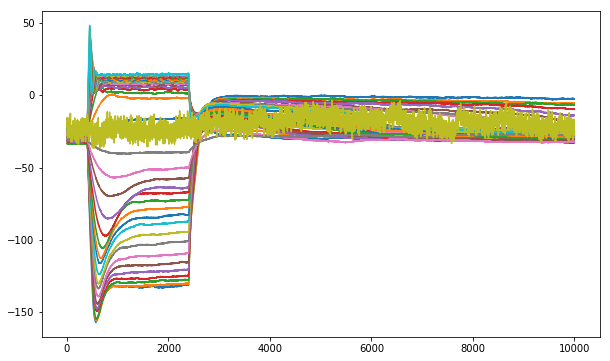

In [41]:
plt.figure(figsize=(10,6))
plot((output/1e-3).transpose());

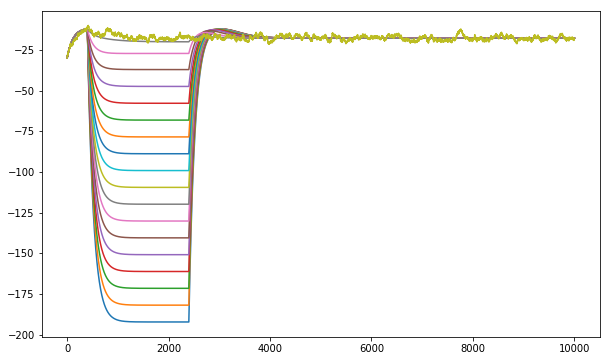

In [42]:
plt.figure(figsize=(10,6))
plot((fits/mV).transpose());